In [1]:
import numpy as np
import itertools
import logging
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd

import torch
import torch.optim as optim
import torch.distributions as dist
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

from nf.flows import NSF_CL, Planar, Radial, RealNVP
from nf.models import NormalizingFlowModel

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [3]:
def plot_data(x, **kwargs):
    plt.scatter(x[:,0], x[:,1], marker="x", **kwargs)
    plt.xlim((-3, 3))
    plt.ylim((-3, 3))

In [4]:
df = pd.read_csv("data.csv")
df

,Time post-injection (months),MBSC Region,iM2,iM1,iAI,iPrL,iMO,iVO,iDP,cM2,...,iSuC,iIC,iPnO,cV-b,cEnt,cPS,cRSA,cSuC,cIC,cPnO
0,1,NTG,0.014842,0.000000,0.003629,0.006650,0.000000,0.011567,0.000189,0.001134,...,0.000000,0.002816,0.000000,0.000000,0.000078,0.000164,0.000000,0.000000,0.000000,0.000108
1,1,NTG,0.227463,0.016372,0.139844,0.044689,0.002673,0.015362,0.016991,0.026859,...,0.000000,0.002742,0.000483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000071
2,1,NTG,0.266335,0.008691,0.028367,0.092924,0.009293,0.009727,0.010178,0.021157,...,0.000000,0.002642,0.000739,0.000193,0.002247,0.000000,0.000000,0.000206,0.000038,0.000079
3,1,NTG,0.042362,0.005238,0.044917,0.021161,0.002880,0.001877,0.010599,0.021431,...,0.000000,0.000833,0.000566,0.000540,0.000000,0.001798,0.000000,0.000000,0.000000,0.000000
4,1,G20,0.023577,0.004621,0.003638,0.000000,0.001450,0.000000,0.000941,0.005575,...,0.000000,0.000332,0.000000,0.000000,0.000102,0.000000,0.000000,0.000000,0.000309,0.000047
5,1,G20,0.324371,0.036880,0.071656,0.011516,0.001394,0.005631,0.002850,0.096962,...,0.000000,0.000495,0.000000,0.000381,0.000000,0.003167,0.000000,0.000000,0.000000,0.000216
6,1,G20,0.016340,0.000567,0.004682,0.000214,0.000276,0.003756,0.000000,0.010201,...,0.000080,0.004816,0.000000,0.006639,0.000379,0.001826,0.000000,0.002939,0.000711,0.003205
7,1,G20,0.135917,0.013436,0.040500,0.043342,0.000000,0.003332,0.017234,0.041776,...,0.000059,0.000417,0.000890,0.000000,0.000000,0.000291,0.000000,0.000000,0.000097,0.000000
8,1,G20,0.058894,0.002256,0.010915,0.024721,0.013671,0.023185,0.002531,0.015196,...,0.000054,0.001459,0.000277,0.000117,0.000000,0.000000,0.000692,0.000000,0.000000,0.000075
9,1,G20,0.103370,0.034662,0.061016,0.004168,0.001304,0.000341,0.006339,0.151783,...,0.000000,0.000812,0.000060,0.000179,0.000000,0.000239,0.000000,0.000000,0.000064,0.000000


In [55]:
x.shape

torch.Size([6, 116])

In [61]:
def gen_data(n, dim):
    torch.manual_seed(0)
    return dist.MultivariateNormal(loc=torch.randn(dim), covariance_matrix=torch.eye(dim)).sample((n, ))

In [64]:
x = gen_data(6, 116)
x.shape

torch.Size([6, 116])

In [69]:
x = df.loc[(df["Time post-injection (months)"] == 6) & (df["MBSC Region"] == "NTG"), 
           [c for c in df.columns if c not in ("MBSC Region", "Time post-injection (months)")]].values
x = torch.from_numpy(x.astype(np.float32))
x = torch.log(x+1e-04)

for i in range(x.shape[1]):
    x[:,i] = (x[:,i] - torch.mean(x[:,i])) / torch.std(x[:,i])

# for dim in range(x.shape[1]):
#     plt.hist(x[:, dim], bins="auto")
#     plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

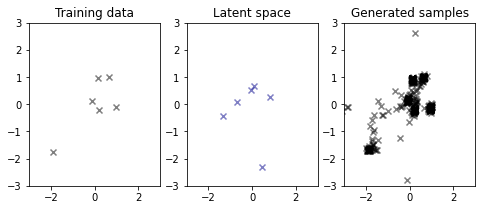

In [70]:
n = 5
flows = 12
flow = NSF_CL # RealNVP
iterations = 1000
use_mixture = False
convolve = False
actnorm = False

dim = x.shape[1]

# flow = eval(args.flow)
flows = [flow(dim=dim) for _ in range(flows)]
if convolve:
    convs = [OneByOneConv(dim=dim) for _ in range(flows)]
    flows = list(itertools.chain(*zip(convs, flows)))
if actnorm:
    actnorms = [ActNorm(dim=dim) for _ in range(flows)]
    flows = list(itertools.chain(*zip(actnorms, flows)))
prior = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
model = NormalizingFlowModel(prior, flows)

optimizer = optim.Adam(model.parameters(), lr=0.005)  # 0.005

# x = get_data() # gen_data(n)

# x = torch.log1p(x)

hist_loss = np.zeros(iterations)

with tqdm(total=iterations) as pbar:
    for i in range(iterations):

        optimizer.zero_grad()
        z, prior_logprob, log_det = model(x)
        logprob = prior_logprob + log_det
        loss = -torch.mean(prior_logprob + log_det)
        loss.backward()
        optimizer.step()

        hist_loss[i] = loss.item()
        if i > 50:
            pbar.set_postfix({'loss': np.mean(hist_loss[i-50:i])})
        pbar.update()

plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1)
plot_data(x, color="black", alpha=0.5)
plt.title("Training data")
plt.subplot(1, 3, 2)
plot_data(z.data, color="darkblue", alpha=0.5)
plt.title("Latent space")
plt.subplot(1, 3, 3)
samples = model.sample(500).data
plot_data(samples, color="black", alpha=0.5)
plt.title("Generated samples")
plt.show()

#     for f in flows:
#         x = f(x)[0].data
#         plot_data(x, color="black", alpha=0.5)
#         plt.show()



In [73]:
with torch.no_grad():
    samples = model.sample(500).data
pd.DataFrame(samples.numpy()).to_csv("samples.csv")

# Solve

$$x_t = e^{-cLt}x_0$$

$$x_t \in \mathbb{R}^N$$
$$c \in \mathbb{R}$$
$$L \in \mathbb{R}^{N \times N}$$
$$t \in \mathbb{R}$$
$$x_0 \in \mathbb{R}^N$$

In [80]:
n = 164
x0 = np.zeros(n)
x0[np.random.randint(n)] = 1.
t = np.random.random()
c = np.random.random()
L = np.random.random((n, n))

In [81]:
xt = np.exp(-c*L*t)@x0

In [82]:
sol = np.linalg.solve(a=np.exp(-c*L*t), b=xt)

In [83]:
np.allclose(x0, sol)

True